In [22]:
# ==============================================================================
# 第一部分：计算代码 (数据处理与模型拟合)
# ==============================================================================

# (1) 导入核心库
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error

# (2) 定义路径
DATA_DIR = '../../Data/0'
RESULT_DIR = 'Result'
os.makedirs(RESULT_DIR, exist_ok=True)

# (3) 加载并清洗数据
processed_file_path = os.path.join(DATA_DIR, '男胎_预处理后数据.csv')
male_df = pd.read_csv(processed_file_path)
print(f"成功加载预处理数据，共 {male_df.shape[0]} 行。")

male_df['Y染色体浓度_is_outlier'] = (male_df['Y染色体浓度'] > male_df['Y染色体浓度'].quantile(0.75) + 1.5 * (male_df['Y染色体浓度'].quantile(0.75) - male_df['Y染色体浓度'].quantile(0.25))).astype(int)
final_filter = (male_df['Y染色体浓度_is_outlier'] == 0) & (male_df['孕周_is_outlier'] == 0) & (male_df['孕妇BMI_is_outlier'] == 0) & (male_df['年龄_is_outlier'] == 0)
male_df_final_clean = male_df[final_filter].copy()
num_removed = len(male_df) - len(male_df_final_clean)
print(f"根据多重离群点标准，移除 {num_removed} 行数据，最终用于分析的数据集共 {len(male_df_final_clean)} 行。")

# (4) 计算并保存相关性分析结果
analysis_df = male_df_final_clean[['Y染色体浓度', '孕周', '孕妇BMI', '年龄']].copy()
corr_table = pd.DataFrame({
    '变量对': ['浓度 vs 孕周', '浓度 vs BMI', '浓度 vs 年龄'],
    '皮尔逊相关系数 (r)': [analysis_df.corr(method='pearson').loc['Y染色体浓度', var] for var in ['孕周', '孕妇BMI', '年龄']],
    '斯皮尔曼相关系数 (ρ)': [analysis_df.corr(method='spearman').loc['Y染色体浓度', var] for var in ['孕周', '孕妇BMI', '年龄']]
}).round(4)
print("\n--- 相关性分析汇总表 ---\n", corr_table)
corr_table.to_csv(os.path.join(RESULT_DIR, '表格1_相关性分析汇总表.csv'), index=False, encoding='utf-8-sig')

# (5) 拟合全部四个模型
model_df = male_df_final_clean[male_df_final_clean['Y染色体浓度'] > 0].copy()
model_m1 = smf.ols('Y染色体浓度 ~ 孕周 + 孕妇BMI + 年龄', data=model_df).fit()
model_m2 = smf.ols('Y染色体浓度 ~ 孕周 + I(孕周**2) + 孕妇BMI + 年龄', data=model_df).fit()
model_m3 = smf.ols('np.log(Y染色体浓度) ~ 孕周 + 孕妇BMI + 年龄', data=model_df).fit()
model_m4 = smf.mixedlm("Y染色体浓度 ~ 孕周 + 孕妇BMI + 年龄", data=model_df, groups=model_df["孕妇代码"]).fit()
print("\n已完成 M1, M2, M3, M4 四个模型的拟合。")

# (6) 计算并保存模型评估对比表
y_true = model_df['Y染色体浓度']
final_metrics = pd.DataFrame({
    '模型': ['M1: 线性回归', 'M2: 多项式回归', 'M3: 指数回归', 'M4: 混合效应模型'],
    '对数似然值': [model_m1.llf, model_m2.llf, model_m3.llf, model_m4.llf],
    'AIC': [model_m1.aic, model_m2.aic, model_m3.aic, model_m4.aic],
    'BIC': [model_m1.bic, model_m2.bic, model_m3.bic, model_m4.bic],
    'RMSE': [np.sqrt(mean_squared_error(y_true, p)) for p in [model_m1.predict(model_df), model_m2.predict(model_df), np.exp(model_m3.predict(model_df)), model_m4.predict(model_df)]]
}).round(2)
print("\n--- 最终四模型评估对比表 ---\n", final_metrics)
final_metrics.to_csv(os.path.join(RESULT_DIR, '表格2_最终四模型评估对比表.csv'), index=False, encoding='utf-8-sig')

# (7) 保存最终模型M4的结果表和摘要
fixed_effects_df = model_m4.summary().tables[1]
fe_table = fixed_effects_df[['Coef.', 'Std.Err.', 'z', 'P>|z|']].copy()
fe_table.columns = ['系数估计值', '标准误', 'z值', 'p值']
variance_table = pd.DataFrame({
    '方差成分': ['个体间方差 (Group Var)', '残差方差 (Scale)'],
    '估计值': [model_m4.cov_re.iloc[0, 0], model_m4.scale]
}).round(4)
fe_table.to_csv(os.path.join(RESULT_DIR, '表格3_最终模型M4_固定效应参数表.csv'), encoding='utf-8-sig')
variance_table.to_csv(os.path.join(RESULT_DIR, '表格4_最终模型M4_方差成分表.csv'), index=False, encoding='utf-8-sig')
print("\n最终模型 M4 的结果表格已保存。")

with open(os.path.join(RESULT_DIR, 'M1_M2_M4_模型详细摘要.txt'), 'w', encoding='utf-8') as f:
    f.write("="*40 + " M1: 多元线性回归 " + "="*40 + "\n"); f.write(str(model_m1.summary()) + "\n\n")
    f.write("="*40 + " M2: 多项式回归 " + "="*40 + "\n"); f.write(str(model_m2.summary()) + "\n\n")
    f.write("="*40 + " M4: 混合效应模型 " + "="*40 + "\n"); f.write(str(model_m4.summary()) + "\n")
print("关键模型的详细摘要已保存至 .txt 文件。")

print("\n--- 计算代码执行完毕 ---")

成功加载预处理数据，共 998 行。
根据多重离群点标准，移除 54 行数据，最终用于分析的数据集共 944 行。

--- 相关性分析汇总表 ---
          变量对  皮尔逊相关系数 (r)  斯皮尔曼相关系数 (ρ)
0   浓度 vs 孕周       0.1069        0.0837
1  浓度 vs BMI      -0.1558       -0.1339
2   浓度 vs 年龄      -0.1141       -0.1008

已完成 M1, M2, M3, M4 四个模型的拟合。

--- 最终四模型评估对比表 ---
            模型    对数似然值      AIC      BIC  RMSE
0    M1: 线性回归  1971.60 -3935.20 -3915.80  0.03
1   M2: 多项式回归  1971.84 -3933.68 -3909.43  0.03
2    M3: 指数回归  -558.40  1124.80  1144.20  0.03
3  M4: 混合效应模型  2235.53      NaN      NaN  0.03

最终模型 M4 的结果表格已保存。
关键模型的详细摘要已保存至 .txt 文件。

--- 计算代码执行完毕 ---


d:\Conda\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


--- 可视化环境准备就绪 ---


C:\Users\86185\AppData\Local\Temp\ipykernel_14564\137092485.py:31: UserWarning: Mismatched number of handles and labels: len(handles) = 0 len(labels) = 2
  plt.legend(handles=handles, labels=[f'保留的数据 (n={len(male_df_final_clean)})', f'剔除的数据 (n={len(male_df) - len(male_df_final_clean)})'], fontsize=16)
C:\Users\86185\AppData\Local\Temp\ipykernel_14564\137092485.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(handles=handles, labels=[f'保留的数据 (n={len(male_df_final_clean)})', f'剔除的数据 (n={len(male_df) - len(male_df_final_clean)})'], fontsize=16)


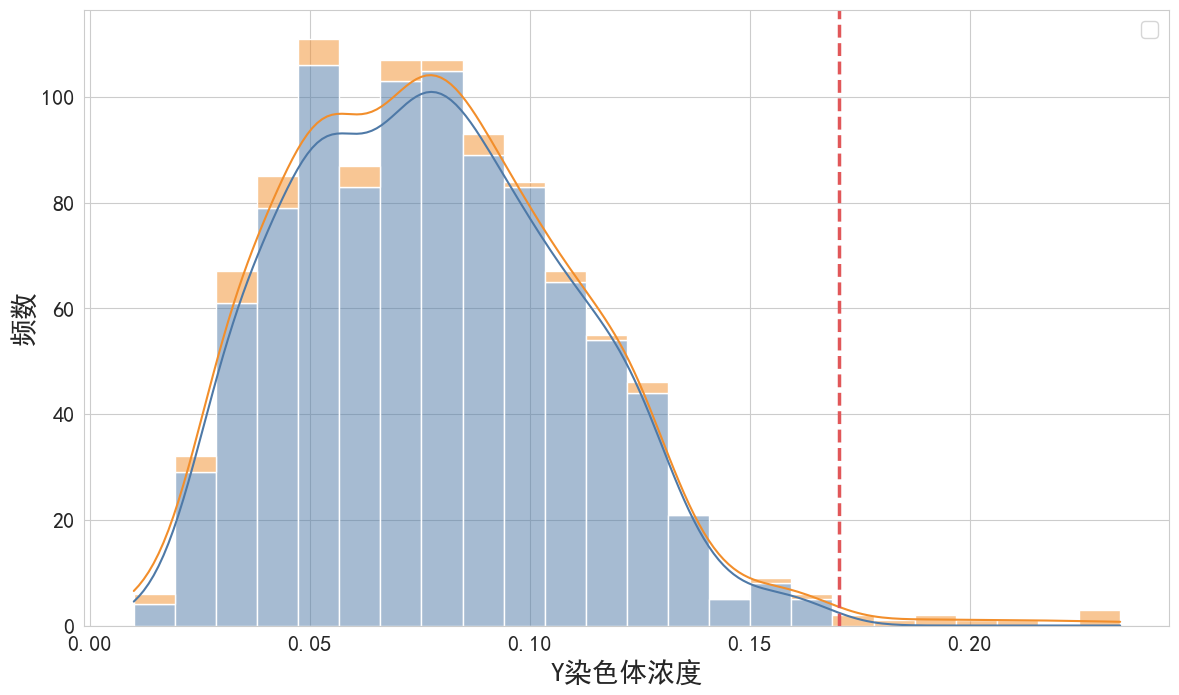

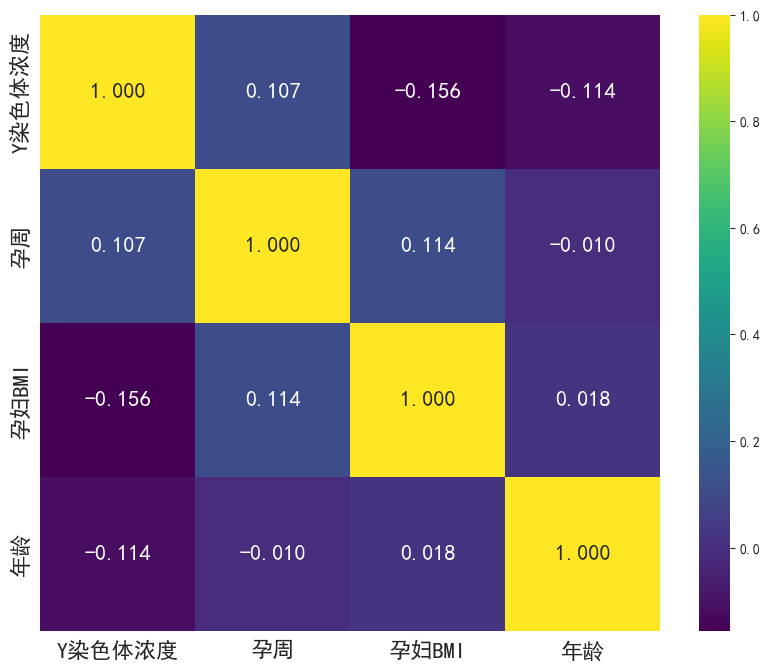

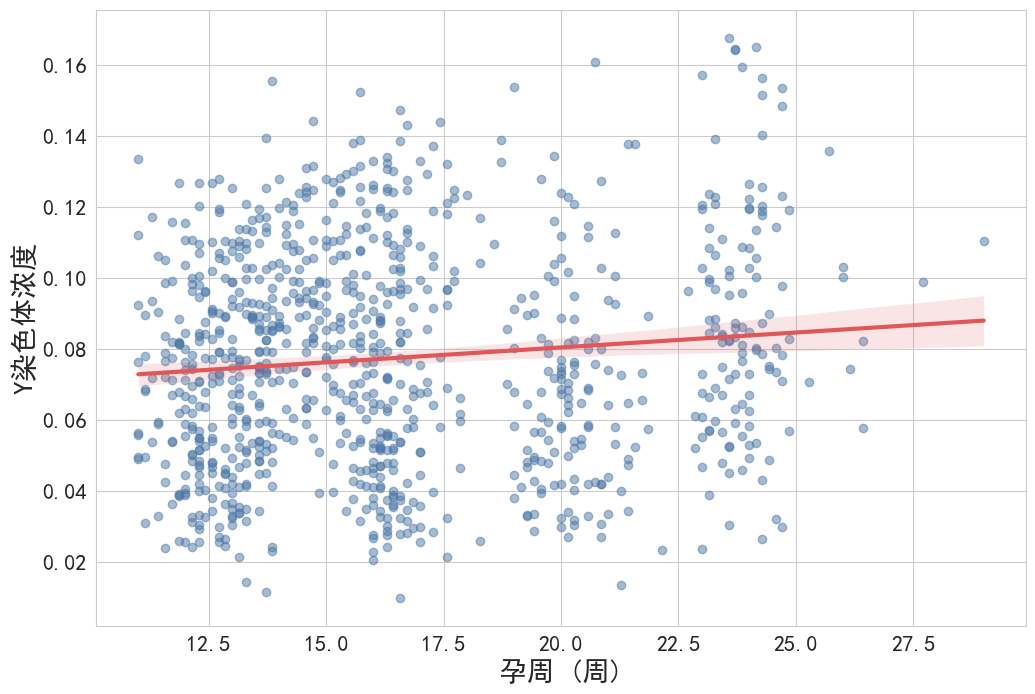

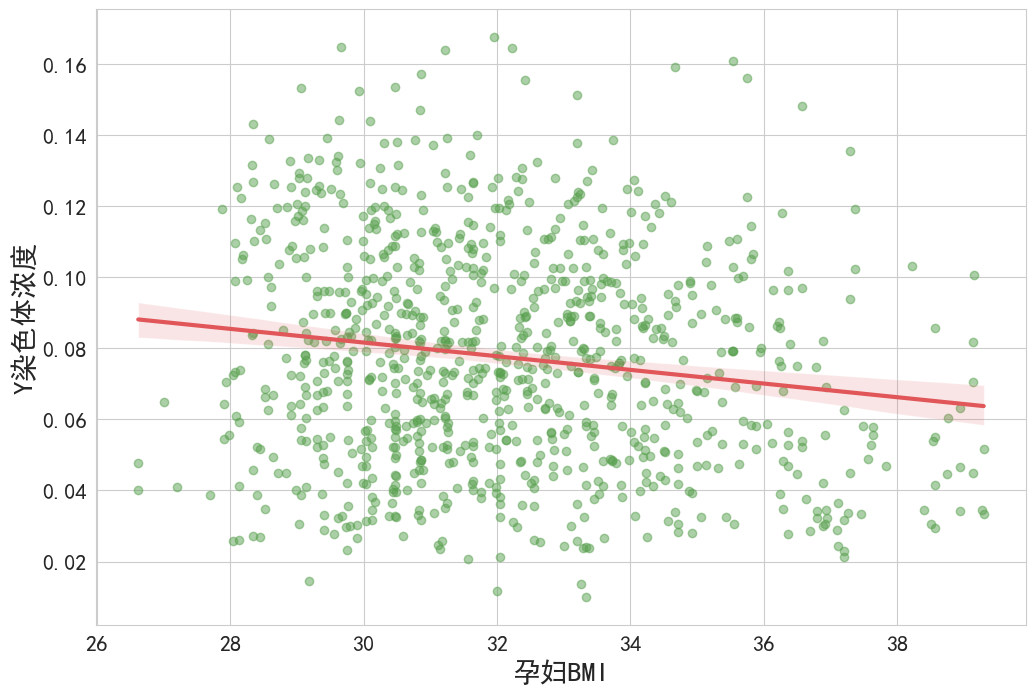

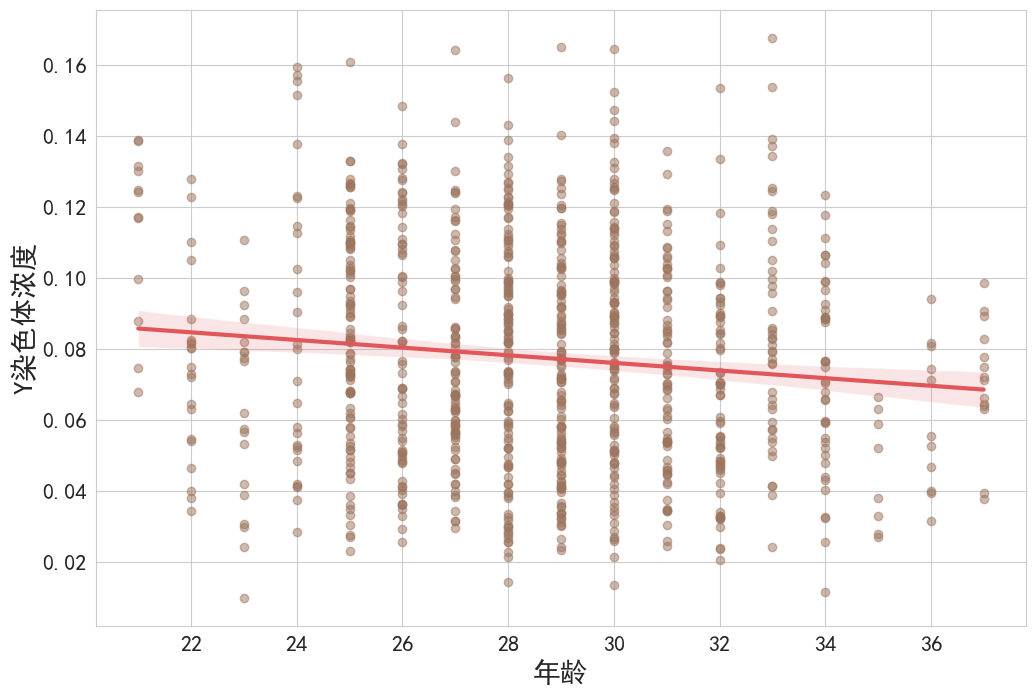

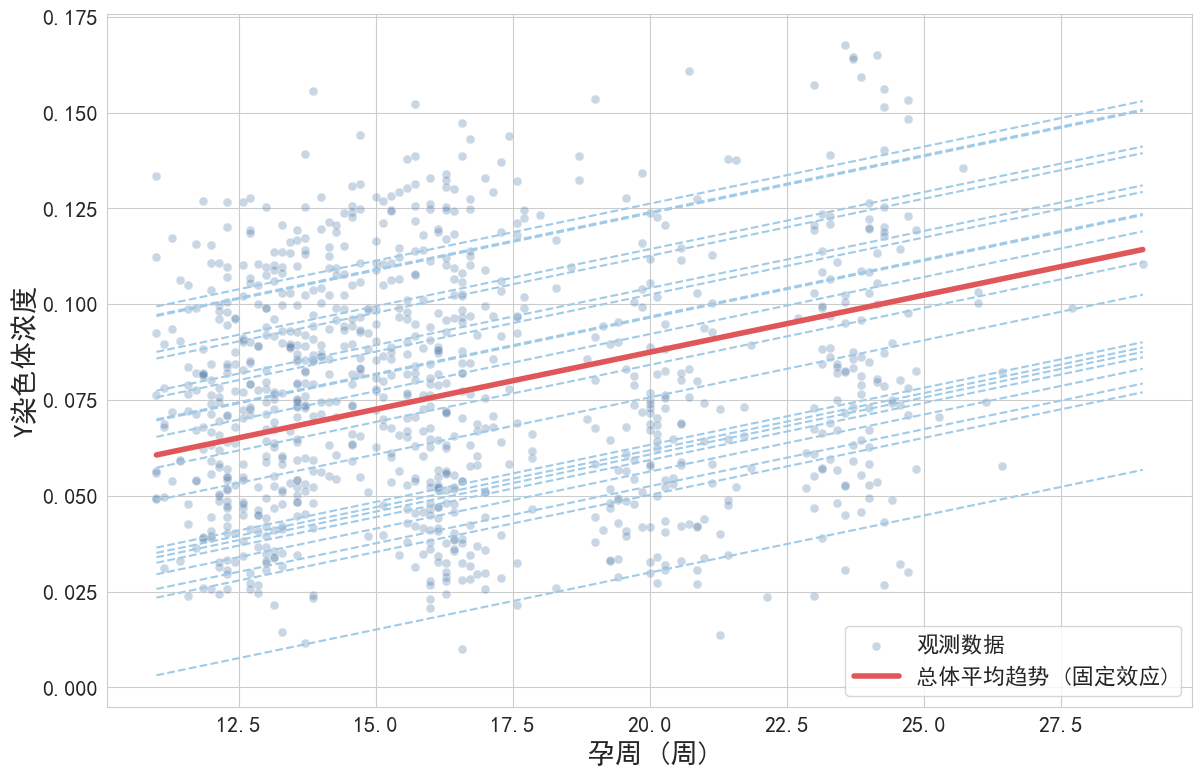


--- 可视化代码执行完毕 ---


In [23]:
# ==============================================================================
# 第二部分：可视化代码 (图表生成与微调)
# ==============================================================================

# (1) 导入绘图库并设置风格
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # 确保numpy已导入

# (2) 定义路径与设置风格 (与计算部分保持一致)
RESULT_DIR = 'Result'
IMAGE_DIR = os.path.join(RESULT_DIR, 'Images_Final_Paper')
os.makedirs(IMAGE_DIR, exist_ok=True)

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
PALETTE = {
    "scatter_main": "#4E79A7", "scatter_alt1": "#59A14F", "scatter_alt2": "#9C755F",
    "line_fit": "#E15759", "outlier": "#F28E2B", "individual_lines": "#A0CBE8"
}
sns.set_style("whitegrid", {"font.sans-serif": ['SimHei', 'Arial']})
print("--- 可视化环境准备就绪 ---")

# (3) 【论文图表1】生成离群点剔除过程可视化图
plt.figure(figsize=(14, 8))
male_df['is_final_kept'] = male_df.index.isin(male_df_final_clean.index)
sns.histplot(data=male_df, x='Y染色体浓度', hue='is_final_kept', palette=[PALETTE['outlier'], PALETTE['scatter_main']], kde=True, multiple="stack")
upper_bound_y = male_df['Y染色体浓度'].quantile(0.75) + 1.5 * (male_df['Y染色体浓度'].quantile(0.75) - male_df['Y染色体浓度'].quantile(0.25))
plt.axvline(x=upper_bound_y, color=PALETTE['line_fit'], linestyle='--', linewidth=2.5)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=[f'保留的数据 (n={len(male_df_final_clean)})', f'剔除的数据 (n={len(male_df) - len(male_df_final_clean)})'], fontsize=16)
plt.xlabel('Y染色体浓度', fontsize=20); plt.ylabel('频数', fontsize=20)
plt.xticks(fontsize=16); plt.yticks(fontsize=16)
plt.savefig(os.path.join(IMAGE_DIR, '图1_Y浓度离群点剔除可视化.png'), dpi=300, bbox_inches='tight')
plt.show()

# (4) 【论文图表2】生成相关性热力图
plt.figure(figsize=(10, 8))
sns.heatmap(analysis_df.corr(method='pearson'), annot=True, cmap='viridis', fmt=".3f", annot_kws={"size": 16})
plt.xticks(fontsize=16); plt.yticks(fontsize=16)
plt.savefig(os.path.join(IMAGE_DIR, '图2_核心变量相关性热力图.png'), dpi=300, bbox_inches='tight')
plt.show()

# (5) 【论文图表3-5】生成核心散点图
scatter_vars = {'孕周': PALETTE['scatter_main'], '孕妇BMI': PALETTE['scatter_alt1'], '年龄': PALETTE['scatter_alt2']}
chart_counter = 3
for var, color in scatter_vars.items():
    plt.figure(figsize=(12, 8))
    sns.regplot(data=analysis_df, x=var, y='Y染色体浓度', scatter_kws={'alpha': 0.5, 'color': color}, line_kws={'color': PALETTE['line_fit'], 'linewidth': 3})
    plt.xlabel(f'{var}{" (周)" if var == "孕周" else ""}', fontsize=20); plt.ylabel('Y染色体浓度', fontsize=20)
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    plt.savefig(os.path.join(IMAGE_DIR, f'图{chart_counter}_Y浓度_vs_{var}_散点图.png'), dpi=300, bbox_inches='tight')
    plt.show()
    chart_counter += 1

# (6) 【论文图表6】生成最终模型M4的可视化图
plt.figure(figsize=(14, 9))
sns.scatterplot(data=model_df, x='孕周', y='Y染色体浓度', color=PALETTE['scatter_main'], alpha=0.3, s=40, label='观测数据')
fe_intercept, fe_slope_gw, fe_slope_bmi, fe_slope_age = model_m4.fe_params
bmi_mean = model_df['孕妇BMI'].mean()
age_mean = model_df['年龄'].mean()
x_range = np.linspace(model_df['孕周'].min(), model_df['孕周'].max(), 100)
y_pop_trend = fe_intercept + fe_slope_gw * x_range + fe_slope_bmi * bmi_mean + fe_slope_age * age_mean
plt.plot(x_range, y_pop_trend, color=PALETTE['line_fit'], linewidth=4, linestyle='-', label='总体平均趋势 (固定效应)')
np.random.seed(42)
random_subjects = np.random.choice(model_df['孕妇代码'].unique(), 20, replace=False)
for subject in random_subjects:
    re_intercept_scalar = model_m4.random_effects[subject].item()
    y_ind_trend = (fe_intercept + re_intercept_scalar) + fe_slope_gw * x_range + fe_slope_bmi * bmi_mean + fe_slope_age * age_mean
    plt.plot(x_range, y_ind_trend, color=PALETTE['individual_lines'], linewidth=1.5, linestyle='--')
plt.xlabel('孕周 (周)', fontsize=20); plt.ylabel('Y染色体浓度', fontsize=20)
plt.xticks(fontsize=16); plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.savefig(os.path.join(IMAGE_DIR, '图6_最终模型M4_可视化.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\n--- 可视化代码执行完毕 ---")